In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
import scipy.signal as signal
import tkinter as tk
from tkinter import filedialog
import os
import seaborn as sns

: 

In [ ]:
main_path = r"Programowanie_Ron_wyniki_AmpOn=1.5_dtOn=0.01_1.csv"
data = pd.read_csv(main_path)
data

,Timestamp,No. pulses,No. Test,R,Succes,dt_Ron,Amp_RonR,q,E_memristor,State
0,1.675702e+09,0,0,19.598154,False,0.01,1.2,0.000000,0.000000,Unknown
1,1.675702e+09,1,0,1.942485,True,0.01,1.2,0.001988,0.000510,R_on
2,1.675702e+09,0,1,491.588277,False,0.01,1.2,0.000000,0.000000,R_off
3,1.675702e+09,1,1,2.040233,True,0.01,1.2,0.001931,0.000547,R_on
4,1.675702e+09,0,2,615.179975,False,0.01,1.2,0.000000,0.000000,R_off
...,...,...,...,...,...,...,...,...,...,...
321,1.675703e+09,0,99,483.967526,False,0.01,1.2,0.000000,0.000000,R_off
322,1.675703e+09,1,99,3.925421,False,0.01,1.2,0.001856,0.000583,Unknown
323,1.675703e+09,2,99,2.800609,True,0.01,1.2,0.001862,0.000580,R_on
324,1.675703e+09,0,100,249.087276,False,0.01,1.2,0.000000,0.000000,R_off


In [3]:
data.columns = ["Time", "Pulses", "Tests",'R','isSucces','dt_Ron',
       'Amp_Ron', 'q', 'E_memristor', 'State']

In [4]:
data.columns

Index(['Time', 'Pulses', 'Tests', 'R', 'isSucces', 'dt_Ron', 'Amp_Ron', 'q',
       'E_memristor', 'State'],
      dtype='object')

In [5]:
data.head()

,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State
0,1.675702e+09,0,0,19.598154,False,0.01,1.2,0.000000,0.000000,Unknown
1,1.675702e+09,1,0,1.942485,True,0.01,1.2,0.001988,0.000510,R_on
2,1.675702e+09,0,1,491.588277,False,0.01,1.2,0.000000,0.000000,R_off
3,1.675702e+09,1,1,2.040233,True,0.01,1.2,0.001931,0.000547,R_on
4,1.675702e+09,0,2,615.179975,False,0.01,1.2,0.000000,0.000000,R_off


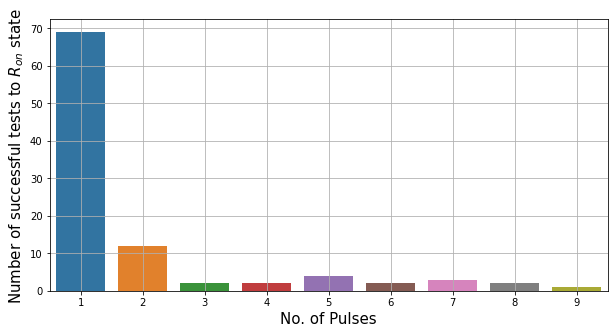

In [6]:

temp_data = data[data["isSucces"]==True].groupby(by="Pulses").count()
plt.figure(figsize=(10,5))
sns.barplot( x=temp_data.index,y="R", data=temp_data)
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Number of successful tests to $R_{on}$ state ", fontsize=15)
plt.grid(True)

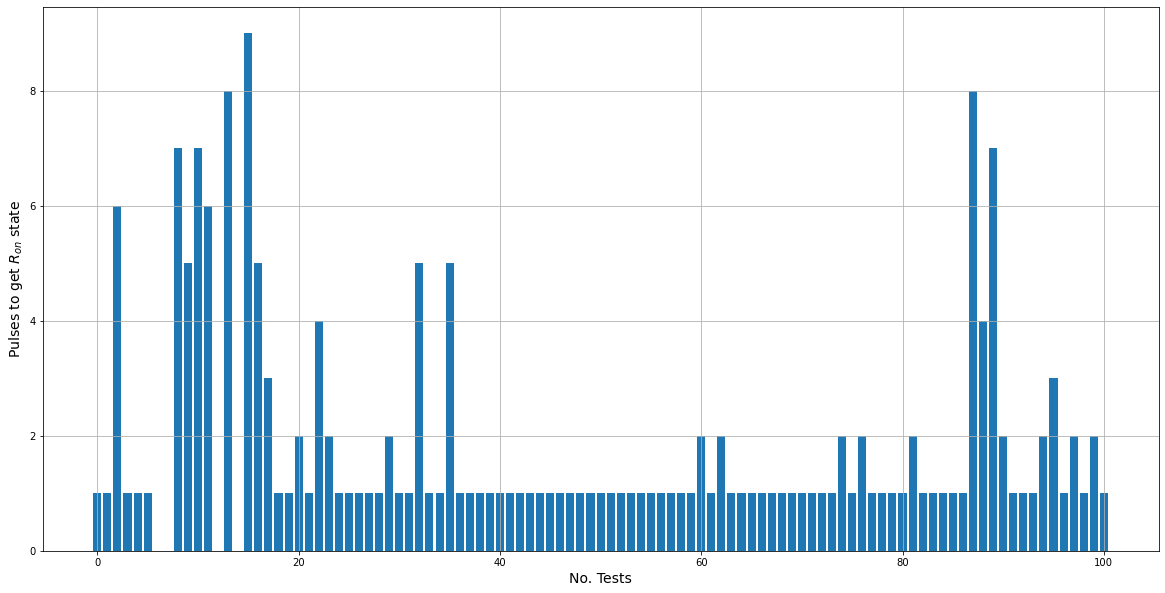

In [7]:
temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["Pulses"],width=0.8)
plt.xlabel("No. Tests",fontdict={'fontsize':14})
plt.ylabel("Pulses to get $R_{on}$ state",fontdict={'fontsize':14})
plt.grid(True)




In [8]:
data['Q_integrated'] = np.nan
data['E_integrated'] = np.nan



for i in data.index:
    if data.loc[i,"q"] == 0:
        data.loc[i,"Q_integrated"] = 0
    else:
        data.loc[i,"Q_integrated"] = data.loc[i-1,"Q_integrated"]+data.loc[i,"q"]
    if data.loc[i,"E_memristor"] == 0:
        data.loc[i,"E_integrated"] = 0
    else:
        data.loc[i,"E_integrated"] = data.loc[i-1,"E_integrated"]+data.loc[i,"E_memristor"]

data['Q_integrated']





0      0.000000
1      0.001988
2      0.000000
3      0.001931
4      0.000000
         ...   
321    0.000000
322    0.001856
323    0.003718
324    0.000000
325    0.001863
Name: Q_integrated, Length: 326, dtype: float64

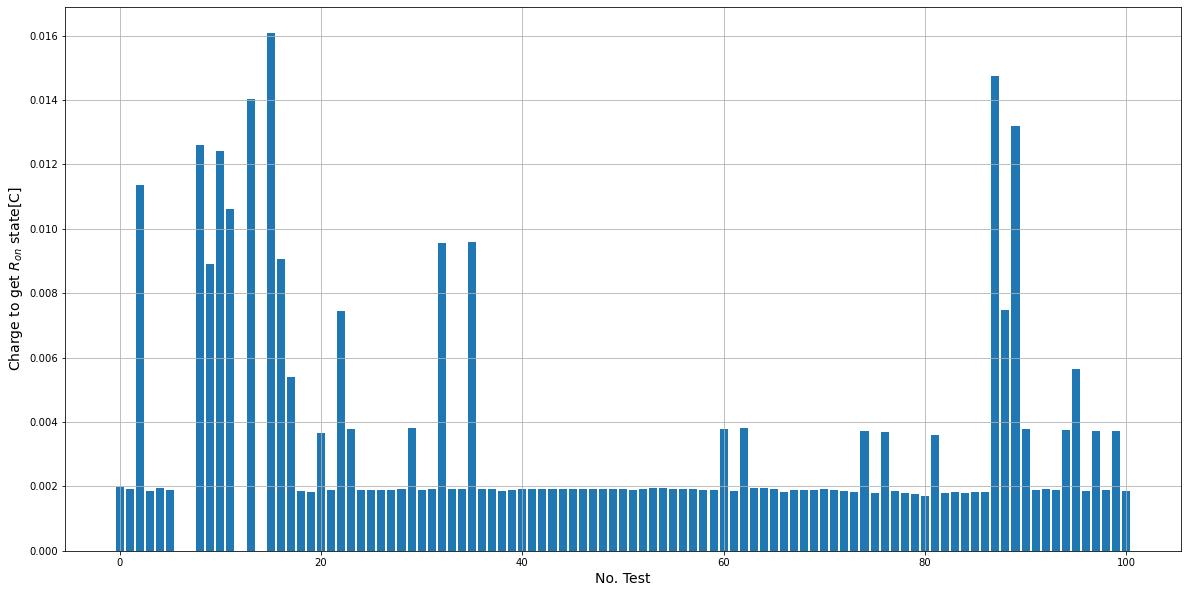

In [9]:
temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["Q_integrated"],width=0.8)
plt.xlabel("No. Test",fontdict={'fontsize':14})
plt.ylabel("Charge to get $R_{on}$ state[C]",fontdict={'fontsize':14})
plt.grid(True)



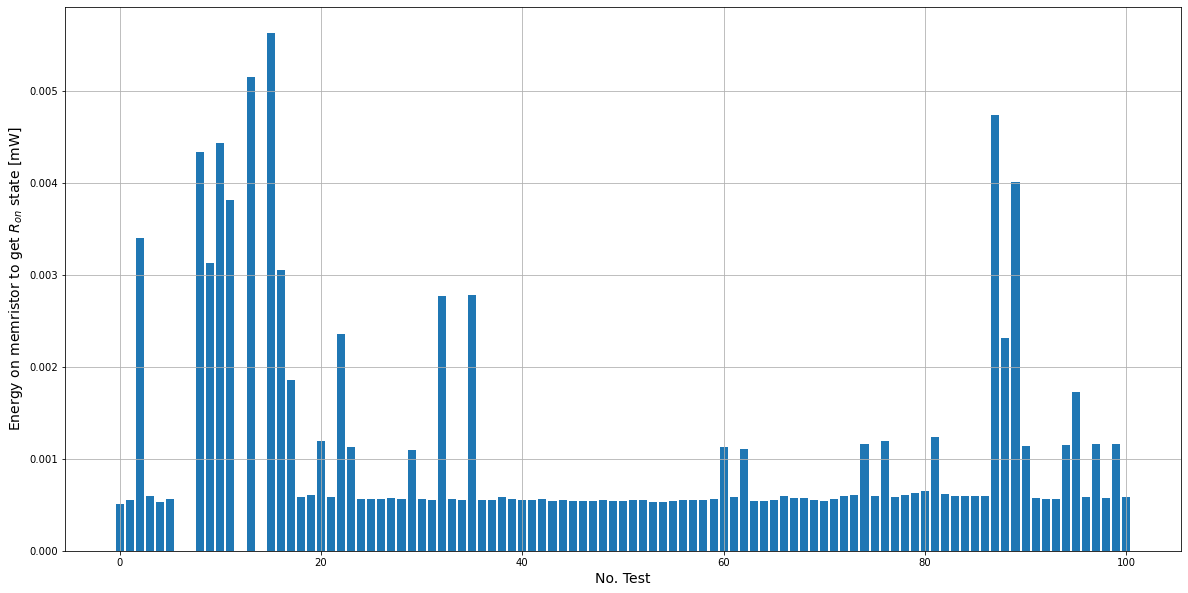

In [10]:

temp_data = data[data["isSucces"]==True]
plt.figure(figsize=(20,10))
plt.bar(x=temp_data["Tests"], height=temp_data["E_integrated"],width=0.8,)
plt.xlabel("No. Test",fontdict={'fontsize':14})
plt.ylabel("Energy on memristor to get $R_{on}$ state [mW]",fontdict={'fontsize':14})
plt.grid(True)


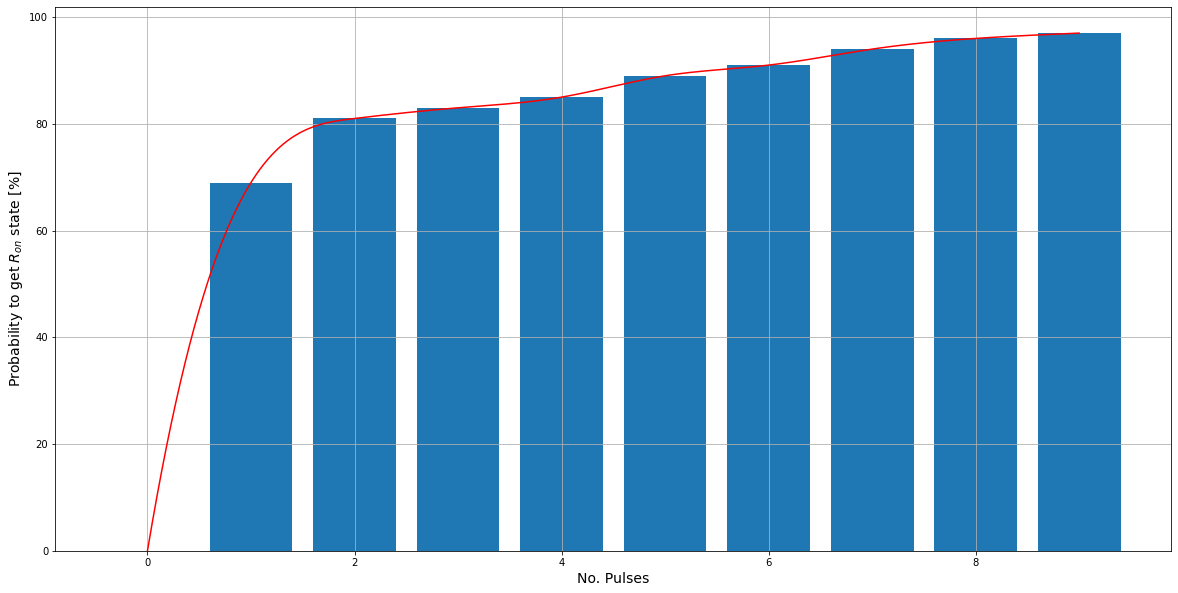

In [11]:
import plotly.express as px
from scipy.interpolate import interp1d

number_of_tests = np.max(data["Tests"])

temp_data = data[data["isSucces"]==True].groupby(by="Pulses",as_index=False).count()
temp_data['Probability'] = np.multiply(temp_data['R'],1/number_of_tests)
temp_data.reset_index(inplace=True)
P = 0
for i in temp_data.index:
    P = temp_data.loc[i,'Probability']+P
    temp_data.loc[i,'Probability'] = P
x = temp_data['Pulses'].to_numpy()
x = np.insert(x,0,0)
y = temp_data['Probability'].to_numpy()
y = np.insert(y,0,0)*100

plt.figure(figsize=(20,10))
plt.bar(x=x, height=y,width=0.8)
plt.xlabel("No. Pulses",fontdict={'fontsize':14})
plt.ylabel("Probability to get $R_{on}$ state [%]",fontdict={'fontsize':14})
plt.grid(True)
x_i = np.arange(start= np.min(x),stop= np.max(x),step=0.001)

cs = interp1d(x, y,kind='cubic')
plt.plot(x_i, cs(x_i),'r') 
#bla bla


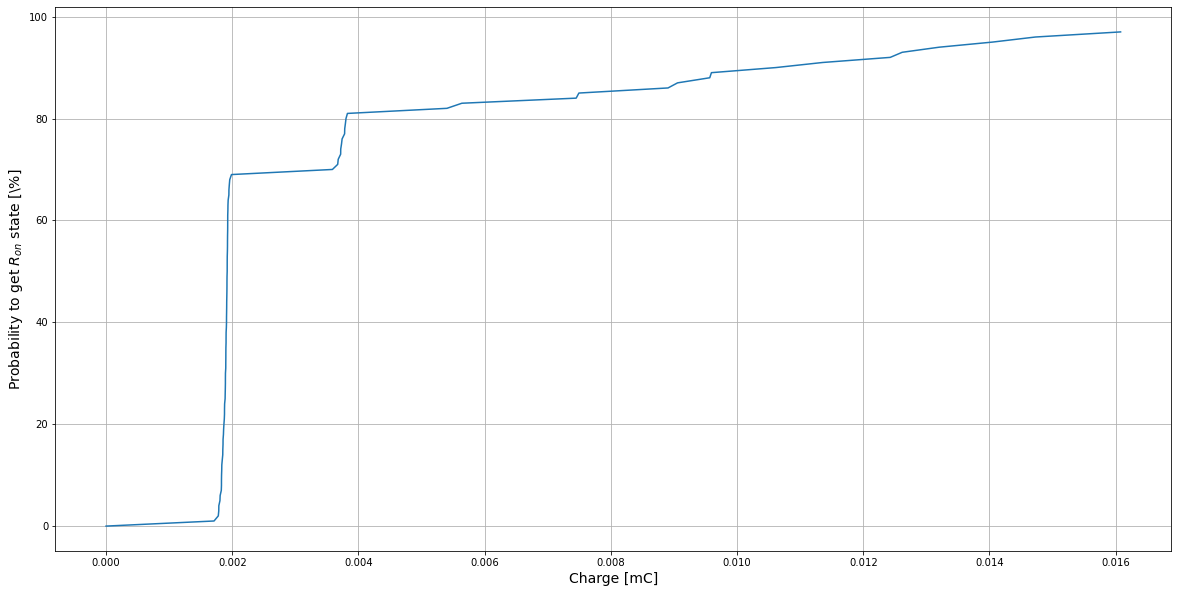

In [12]:

number_of_tests = np.max(data["Tests"])

temp_data = data[data["isSucces"]==True].groupby(by="Q_integrated",as_index=False).count()
temp_data.sort_values(by="Q_integrated",ascending=True,inplace=True)
temp_data.reset_index(drop=True,inplace=True)
temp_data

temp_data['Probability'] = np.multiply(temp_data['R'],1/number_of_tests)
P = 0

for i in temp_data.index:
    P = temp_data.loc[i,'Probability']+P
    temp_data.loc[i,'Probability'] = P

x = temp_data['Q_integrated'].to_numpy()
x = np.insert(x,0,0)
y = temp_data['Probability'].to_numpy()
y = np.insert(y,0,0)*100

plt.figure(figsize=(20,10))
plt.plot(x, y)
plt.xlabel("Charge [mC]",fontdict={'fontsize':14})
plt.ylabel("Probability to get $R_{on}$ state [\%]",fontdict={'fontsize':14})
plt.grid(True)
x_i = np.arange(start= np.min(x),stop= np.max(x),step=0.001)

cs = interp1d(x, y,kind='previous')
#plt.plot(x_i, cs(x_i),'r')




In [13]:
data

,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State,Q_integrated,E_integrated
0,1.675702e+09,0,0,19.598154,False,0.01,1.2,0.000000,0.000000,Unknown,0.000000,0.000000
1,1.675702e+09,1,0,1.942485,True,0.01,1.2,0.001988,0.000510,R_on,0.001988,0.000510
2,1.675702e+09,0,1,491.588277,False,0.01,1.2,0.000000,0.000000,R_off,0.000000,0.000000
3,1.675702e+09,1,1,2.040233,True,0.01,1.2,0.001931,0.000547,R_on,0.001931,0.000547
4,1.675702e+09,0,2,615.179975,False,0.01,1.2,0.000000,0.000000,R_off,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
321,1.675703e+09,0,99,483.967526,False,0.01,1.2,0.000000,0.000000,R_off,0.000000,0.000000
322,1.675703e+09,1,99,3.925421,False,0.01,1.2,0.001856,0.000583,Unknown,0.001856,0.000583
323,1.675703e+09,2,99,2.800609,True,0.01,1.2,0.001862,0.000580,R_on,0.003718,0.001162
324,1.675703e+09,0,100,249.087276,False,0.01,1.2,0.000000,0.000000,R_off,0.000000,0.000000


In [14]:
temp_data = data[data['State'] == "Unknown"]
temp_data


,Time,Pulses,Tests,R,isSucces,dt_Ron,Amp_Ron,q,E_memristor,State,Q_integrated,E_integrated
0,1.675702e+09,0,0,19.598154,False,0.01,1.2,0.000000,0.000000,Unknown,0.000000,0.000000
5,1.675702e+09,1,2,5.054541,False,0.01,1.2,0.001858,0.000591,Unknown,0.001858,0.000591
6,1.675702e+09,2,2,5.007797,False,0.01,1.2,0.001897,0.000568,Unknown,0.003756,0.001160
7,1.675702e+09,3,2,5.172865,False,0.01,1.2,0.001907,0.000562,Unknown,0.005663,0.001722
8,1.675702e+09,4,2,4.300951,False,0.01,1.2,0.001887,0.000564,Unknown,0.007550,0.002287
...,...,...,...,...,...,...,...,...,...,...,...,...
308,1.675703e+09,1,94,3.256495,False,0.01,1.2,0.001870,0.000574,Unknown,0.001870,0.000574
311,1.675703e+09,1,95,3.991098,False,0.01,1.2,0.001882,0.000568,Unknown,0.001882,0.000568
312,1.675703e+09,2,95,3.145921,False,0.01,1.2,0.001878,0.000580,Unknown,0.003760,0.001148
317,1.675703e+09,1,97,3.472473,False,0.01,1.2,0.001862,0.000589,Unknown,0.001862,0.000589


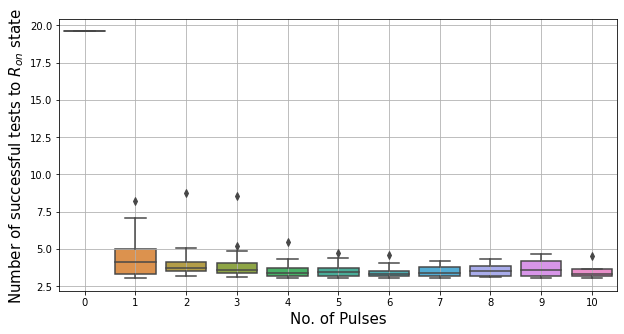

In [15]:
plt.figure(figsize=(10,5))
sns.boxplot(data=temp_data, x="Pulses",y="R")
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Number of successful tests to $R_{on}$ state ", fontsize=15)
plt.grid(True)

In [16]:
temp_data = data[data['Pulses'] != 0]

(0.0, 25.0)

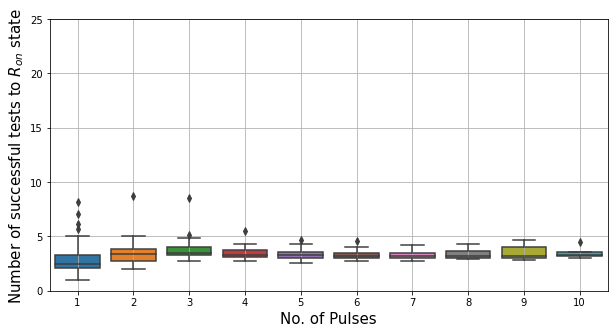

In [17]:
plt.figure(figsize=(10,5))
sns.boxplot(data=temp_data, x="Pulses",y="R")
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Number of successful tests to $R_{on}$ state ", fontsize=15)
plt.grid(True)
plt.ylim((0,25))

In [18]:
k = np.logical_and( temp_data["Pulses"]>=4, temp_data["R"]>=100 )
k = np.where(k==True)
temp_data.iloc[k[0]]
temp_data =temp_data.drop(labels = k[0],axis=0).reset_index(drop=True)
temp_data.max()

Time            1675702780.018402
Pulses                         10
Tests                         100
R                        8.765578
isSucces                     True
dt_Ron                       0.01
Amp_Ron                       1.2
q                        0.001988
E_memristor              0.000659
State                     Unknown
Q_integrated             0.018014
E_integrated             0.006448
dtype: object

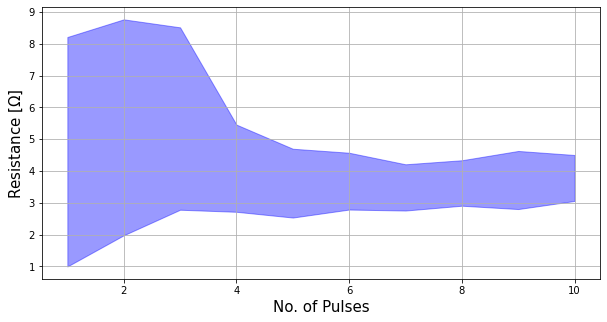

In [19]:
plt.figure(figsize=(10,5))
max = temp_data.groupby('Pulses').max()["R"]
min = temp_data.groupby('Pulses').min()["R"]
plt.fill_between(max.index, max, min, alpha=0.4, color='blue')
plt.xlabel("No. of Pulses", fontsize=15)
plt.ylabel("Resistance $[\Omega]$ ", fontsize=15)
plt.grid(True)
#plt.ylim((0,25))

In [24]:
data[data['State']=="R_off"].min()

Time            1675702072.047156
Pulses                          0
Tests                           1
R                      179.203629
isSucces                    False
dt_Ron                       0.01
Amp_Ron                       1.2
q                             0.0
E_memristor                   0.0
State                       R_off
Q_integrated                  0.0
E_integrated                  0.0
dtype: object